In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

## Preprocess Data

In [2]:
df = pd.read_csv("../dataset/train.csv")

In [3]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [5]:
MAX_FEATURES = 200000 # number of words in the vocab

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
print(vectorizer)

In [6]:
vectorizer.adapt(X.values)

In [7]:
vectorized_text = vectorizer(X.values)

In [8]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8) # helps bottlenecks

In [9]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Creation of Sequential Model

In [10]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [11]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [12]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
3490/3490 [==============================] - 2759s 789ms/step - loss: 0.0634 - val_loss: 0.0456
Epoch 2/5
3490/3490 [==============================] - 2551s 731ms/step - loss: 0.0450 - val_loss: 0.0398
Epoch 3/5
3490/3490 [==============================] - 2570s 736ms/step - loss: 0.0400 - val_loss: 0.0358
Epoch 4/5
3490/3490 [==============================] - 2607s 747ms/step - loss: 0.0360 - val_loss: 0.0312
Epoch 5/5
3490/3490 [==============================] - 2618s 750ms/step - loss: 0.0317 - val_loss: 0.0277


{'loss': [0.06336843222379684, 0.04500362277030945, 0.04003480076789856, 0.03598280996084213, 0.031683631241321564], 'val_loss': [0.045620691031217575, 0.03980737552046776, 0.03578878566622734, 0.031212814152240753, 0.027722720056772232]}


<Figure size 576x360 with 0 Axes>

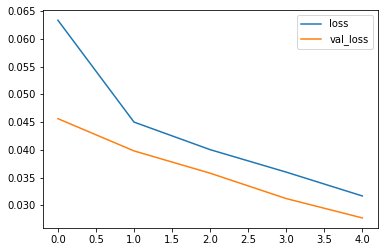

In [13]:
print(history.history)

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Make Predictions

In [14]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.expand_dims(input_text,0))

In [15]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [16]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [17]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [18]:
res.shape

(1, 6)

## Model Evaluation

In [19]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [20]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.887333333492279, Recall:0.8208448886871338, Accuracy:0.34939759969711304


In [21]:
model.save('../models/model.h5')